In [175]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
import statsmodels.api as sm 
import seaborn as sns
from itertools import combinations
from tqdm import tqdm
import seaborn as sns
%matplotlib inline

In [176]:
df  = pd.read_csv('./for_images.csv', index_col=0)

In [177]:
#making 0 values null for death year
df.loc[(df['death_year'] == 0), 'death_year'] = np.nan

In [178]:
numeric = df.copy()
#excluding non-numeric dtypes
numeric = numeric.select_dtypes(exclude='object')
#eliminating living presidents
numeric = numeric.dropna(subset=['years_lived']).reset_index(drop=True)
#covariance modeled better linearly with following tranformation
numeric['sqrt_rank'] = np.sqrt(numeric['rank'])
#
numeric['pres_length_and_rank'] = numeric['presidency_length'] * numeric['rank']

In [179]:
np.abs(numeric.corr()['Words on Page']).sort_values()

years_lived_after_pres       0.051646
years_lived                  0.074459
profile_dates_std            0.216356
age_become_pres              0.220858
pres_length_and_rank         0.293424
First Year of Presidency     0.353550
death_year                   0.355492
cos_similarity_wiki_inaug    0.361139
sim_rank                     0.363360
birth_year                   0.374820
presidency_length            0.382782
more_than_10000_deaths       0.448133
Num Wiki References          0.514382
profile_dates_mean           0.517599
rank                         0.612962
sqrt_rank                    0.627519
Words on Page                1.000000
Name: Words on Page, dtype: float64

In [180]:
#dropping similarity ranking measures
numeric = numeric.drop(['cos_similarity_wiki_inaug'], axis=1)
#imputing the mean value for presidents that didnt deliver inaugural (probably not completely fair
#as they never won office subsequently and probably arent rated highly)
numeric['sim_rank'] = numeric.sim_rank.fillna(np.mean(numeric.sim_rank))

In [181]:
#dropping perfectly correlated columns
numeric = numeric.drop(['First Year of Presidency', 'death_year', 'years_lived'], axis=1)

In [182]:
y = numeric['Words on Page']
X = numeric.drop('Words on Page', axis=1)
ss = StandardScaler()
X = ss.fit_transform(X)
X = pd.DataFrame(X)
X.columns = numeric.drop('Words on Page', axis=1).columns

In [183]:
#ols.rsquared_adj

In [184]:
X.shape

(38, 12)

In [185]:
variables = []
adj_r = []
for i in tqdm(range(1, 13)):
    combos = list(combinations(list(X.columns), i))
    for co in combos:
        variables.append(co)
        df = X.copy()
        df = df[list(co)]
        df = sm.add_constant(df)
        ols = sm.OLS(y, df).fit()
        adj_r.append(ols.rsquared_adj)

100%|██████████| 12/12 [00:12<00:00,  1.02s/it]


In [186]:
len(variables) #1023 combinations of features

4095

In [187]:
print(adj_r[adj_r.index(max(adj_r))])
print(variables[adj_r.index(max(adj_r))])

0.5924911576082319
('Num Wiki References', 'profile_dates_mean', 'profile_dates_std', 'more_than_10000_deaths', 'sim_rank', 'pres_length_and_rank')


(2, 10)

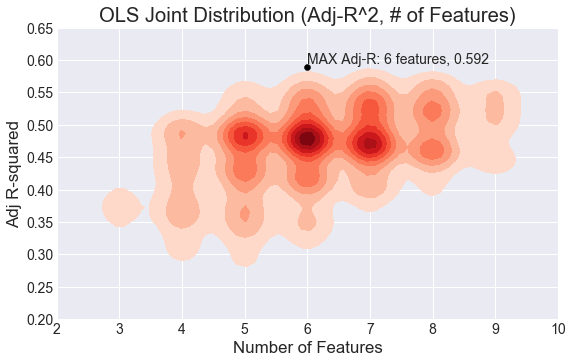

In [195]:
fig, ax = plt.subplots(figsize=(8,5))
plt.style.use('fivethirtyeight')
sns.set_style('darkgrid')
sns.kdeplot([len(x) for x in variables],adj_r, cmap='Reds', shade=True, shade_lowest=False)
plt.title('OLS Joint Distribution (Adj-R^2, # of Features)')
plt.scatter(6, 0.59, c='black')
plt.xlabel('Number of Features')
plt.ylabel('Adj R-squared')
plt.annotate(s='MAX Adj-R: 6 features, 0.592',xy=(6, 0.595))
plt.ylim((0.2,0.65))
plt.xlim((2, 10))

In [198]:
df = X.copy()
df = df[['Num Wiki References', 'profile_dates_mean', 'profile_dates_std', 
         'more_than_10000_deaths', 'sim_rank', 'pres_length_and_rank']]
df = sm.add_constant(df)
ols = sm.OLS(y, df).fit()
print(ols.summary())

                            OLS Regression Results                            
Dep. Variable:          Words on Page   R-squared:                       0.659
Model:                            OLS   Adj. R-squared:                  0.592
Method:                 Least Squares   F-statistic:                     9.966
Date:                Wed, 02 May 2018   Prob (F-statistic):           3.89e-06
Time:                        11:50:42   Log-Likelihood:                -409.53
No. Observations:                  38   AIC:                             833.1
Df Residuals:                      31   BIC:                             844.5
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                             coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------
const                   7.94

In [201]:
#same thing without wiki references
X = X.drop(['Num Wiki References'], axis=1)
variables = []
adj_r = []
for i in tqdm(range(1, 12)):
    combos = list(combinations(list(X.columns), i))
    for co in combos:
        variables.append(co)
        df = X.copy()
        df = df[list(co)]
        df = sm.add_constant(df)
        ols = sm.OLS(y, df).fit()
        adj_r.append(ols.rsquared_adj)

print(adj_r[adj_r.index(max(adj_r))])
print(variables[adj_r.index(max(adj_r))])

100%|██████████| 11/11 [00:06<00:00,  1.65it/s]


In [204]:
df = X.copy()
df = df[['profile_dates_mean', 'profile_dates_std', 'sqrt_rank', 'pres_length_and_rank']]
df = sm.add_constant(df)
ols = sm.OLS(y, df).fit()
print('R-squared w/o wiki references', ols.rsquared)

R-squared w/o wiki references 0.5657608214467682
